<a href="https://colab.research.google.com/github/scaairesearch/da_demo/blob/main/da_mnist_demo_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Domain Adaptation Demonstration
- get data
- create model architecture
- train baseline and non-da
- save models
- infer model
- grad cam on correctly classified and misclassified images
- mis classified images

# Objective / Target
**Objective / Target**
* Increase accuracy by increasing capacity
* Play with LR

**Results**

* Parameters: 7,900
* Best Train Accuracy: 98.91
* Best Test Accuracy: 99.31

**Analysis**

* Not Able to hit the accuracy mark
* Overfitting (train - test accuracy) < 0 is largely containted, model underfits (Target not achieved)
* LR has played its role to move up the accuracy
* Number of params < 8K
* Adding params near output helped much, so did removing input

**Next Steps**

* Play with large LR


# Importing Libraries

In [ ]:
import torch
from torchvision import datasets,transforms
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt # for visualizing images
import random # for random image index
import torch.nn as nn # for network
import torch.nn.functional as F # for forward method
import torch.optim as optim # for optimizer
!pip install torchsummary
from torchsummary import summary # for model summary and params
from tqdm import tqdm # for beautiful model training updates
# from torch.utils.data import dataset # for MNISTM dataset
from PIL import Image
import os
from torch.optim.lr_scheduler import ReduceLROnPlateau
from copy import deepcopy


## Seed and Cuda

In [ ]:
# check for cuda
cuda = torch.cuda.is_available()
print (f' Cuda Status : {cuda}')

# setting seed
SEED = 42 # arbit seed, why 42 - because in hitch hikers guide to galaxy it is answer to everything
# torch.cuda.seed(SEED)
torch.cuda.manual_seed_all(SEED) if cuda else torch.manual_seed(SEED)

device = torch.device("cuda" if cuda else "cpu")
print(device)

 Cuda Status : False
cpu


### Constants

In [ ]:
img_size = 28 # for mnist
cpu_batch_size = 64
cuda_batch_size = 128
EPOCHS = 2 # 15 if cuda else 2

target_drive_path = '/content/gdrive/MyDrive/mnist_m/dataset/mnist_m.tar.gz'


data_base_path = '/content/data'
source_dataset_name = 'MNIST'
target_dataset_name = 'mnist_m'
source_image_root = os.path.join(data_base_path, source_dataset_name)
target_image_root = os.path.join(data_base_path, target_dataset_name)
model_root = 'models'
# cuda = True
# cudnn.benchmark = True
lr = 1e-3
# batch_size = 128
# image_size = 28
# n_epoch = 100

# Source Data

## Data Transforms

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.Resize(img_size),
                                      #  transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(), # converts to tesnor
                                       transforms.Normalize((0.1307,), (0.3081,)) # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.Resize(img_size),
                                       transforms.ToTensor(),# converts to tesnor
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


## Dataset and Creating Train / Test Split

In [ ]:
train = datasets.MNIST('./data', # directory where data needs to be stored
                       train=True, # get the training portion of the dataset
                       download=True, # downloads
                       transform=train_transforms)
test = datasets.MNIST('./data',
                      train=False,
                      download=True,
                      transform=test_transforms)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 47770109.06it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1701535.20it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 13520407.80it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4003894.23it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Data Loader

In [ ]:
dataloader_args = dict(shuffle=True, batch_size=cuda_batch_size, num_workers=4, pin_memory = True) if cuda else dict(shuffle=True, batch_size=cpu_batch_size)

train_loader = torch.utils.data.DataLoader(
    dataset=train,# train dataset
    **dataloader_args # the dataloader arguments change dependent on cuda is available or not
    )

test_loader = torch.utils.data.DataLoader(
    dataset = test,# test dataset
    **dataloader_args # the dataloader arguments change dependent on cuda is available or not
)

## Checking Dataloader

In [ ]:
# next(iter(train_loader))

torch.Size([64, 1, 28, 28]) torch.Size([64])
Label = 0


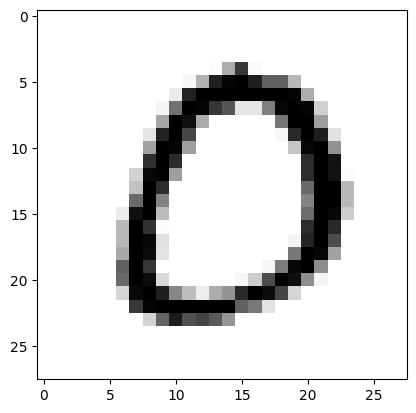

In [ ]:
images, labels  = next(iter(train_loader))
print(images.shape, labels.shape)
# printing random image and seeing
random_idx = random.randint(0,len(images))
plt.imshow(images[random_idx].numpy().squeeze(), cmap='gray_r')
print(f'Label = {labels[random_idx].item()}' )

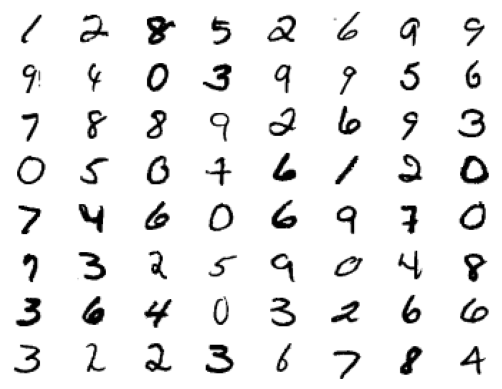

In [ ]:
# Looking at more images
figure = plt.figure()
for index in range(1, len(images) + 1): # assumption: batch size would be atleast 8
    plt.subplot(8, int(len(images)/8), index)
    plt.axis('off')
    plt.imshow(images[index-1].numpy().squeeze(), cmap='gray_r')

# Target Data

## Data Transforms

In [ ]:
# Train Phase transformations
target_train_transforms = transforms.Compose([
                                       transforms.Resize(img_size),
                                      #  transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(), # converts to tesnor
                                       transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                                       ])

# Test Phase transformations
target_test_transforms = transforms.Compose([
                                       transforms.Resize(img_size),
                                       transforms.ToTensor(),# converts to tesnor
                                       transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                                       ])

## Dataset Class

In [ ]:
class MNISTM(torch.utils.data.Dataset):
    def __init__(self, data_root, data_list, transform=None):
        self.root = data_root
        self.transform = transform

        f = open(data_list, 'r')
        data_list = f.readlines()
        f.close()

        self.n_data = len(data_list)

        self.img_paths = []
        self.img_labels = []

        for data in data_list:
            self.img_paths.append(data[:-3])
            self.img_labels.append(data[-2])

    def __getitem__(self, item):
        img_paths, labels = self.img_paths[item], self.img_labels[item]
        imgs = Image.open(os.path.join(self.root, img_paths)).convert('RGB')

        if self.transform is not None:
            imgs = self.transform(imgs)
            labels = int(labels)

        return imgs, labels

    def __len__(self):
        return self.n_data

## Dataset

In [ ]:
# checking the mounted drive and mounting if not done
if not os.path.exists('/content/gdrive'):
  from google.colab import drive
  drive.mount('/content/gdrive')
else:
    print("Google Drive is already mounted.")

Mounted at /content/gdrive


## Extracting Dataset - one time

In [ ]:
import tarfile
import os
from pathlib import Path

if os.path.exists(target_drive_path):
    with tarfile.open(target_drive_path, 'r:gz') as tar:
      tar.extractall(path=data_base_path)
else:
    print(f"The directory {target_drive_path} does not exist.")

In [ ]:
train_list = os.path.join(target_image_root, 'mnist_m_train_labels.txt')
train_root = os.path.join(target_image_root, 'mnist_m_train')
test_list = os.path.join(target_image_root, 'mnist_m_test_labels.txt')
test_root = os.path.join(target_image_root, 'mnist_m_test')

dataset_target_train = MNISTM(data_root = train_root,
                                 data_list = train_list,
                                 transform = target_train_transforms,
                                 )
dataset_target_test = MNISTM(data_root = test_root,
                                      data_list = test_list,
                                      transform = target_test_transforms,
                                      )

## Dataloader

In [ ]:

dataloader_target_train = torch.utils.data.DataLoader(
    dataset=dataset_target_train,# train dataset
    **dataloader_args # the dataloader arguments change dependent on cuda is available or not
    )

dataloader_target_train = torch.utils.data.DataLoader(
    dataset = dataset_target_test,# test dataset
    **dataloader_args # the dataloader arguments change dependent on cuda is available or not
)

### Checking Dataloader

torch.Size([128, 3, 28, 28]) torch.Size([128])
Label = 1


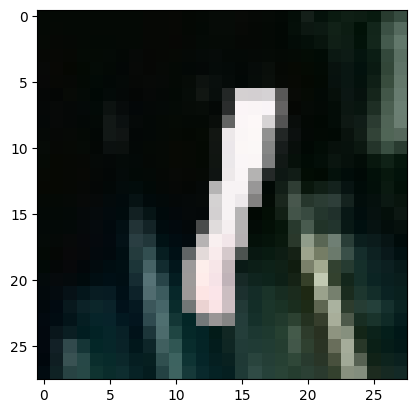

In [ ]:
images, labels  = next(iter(dataloader_target_train))
print(images.shape, labels.shape)
# printing random image and seeing
random_idx = random.randint(0,len(images))
random_img = images[random_idx].permute(1,2,0).numpy()
plt.imshow((random_img*0.5)+0.5)
print(f'Label = {labels[random_idx].item()}' )

# Model

In [ ]:
# class Network(nn.Module):
#   def __init__(self):
#     super(Network,self).__init__() # extending super class method

#     drop_out_value = 0.1

#     # Input Block
#     self.convblock1 = nn.Sequential(
#         nn.Conv2d(3,16,3 , bias= False ), # In- 3x28x28, Out- 16x26x26, RF- 3x3, Jump_in -1, Jump_out -1
#         nn.ReLU(),
#         nn.BatchNorm2d(16),# affine=False),
#         nn.Dropout(drop_out_value)
#     )

#     # Conv Block 2
#     self.convblock2 = nn.Sequential(
#         nn.Conv2d(16,16,3, bias= False ), # In- 16x26x26, Out- 16x24x24, RF- 5x5, Jump_in -1, Jump_out -1
#         nn.ReLU(),
#         nn.BatchNorm2d(16),# affine=False),
#         nn.Dropout(drop_out_value)
#     )

#     # Conv Block 3
#     self.convblock3 = nn.Sequential(
#         nn.Conv2d(16,16,3, bias= False ), # In- 16x24x24, Out- 16x22x22, RF- 7x7, Jump_in -1, Jump_out -1
#         nn.ReLU(),
#         nn.BatchNorm2d(16),# affine=False),
#         nn.Dropout(drop_out_value)
#     )

#     # Transition Block 1 (this also includes a conv block)
#     self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # In- 16x22x22, Out- 16x11x11, RF- 8x8, Jump_in -1, Jump_out -2


#     # Conv Block 4
#     self.convblock4 = nn.Sequential(
#         nn.Conv2d(16,16,3, bias= False ), # In- 16x11x11, Out- 16x9x9, RF- 12x12, Jump_in -2, Jump_out -2
#         nn.ReLU(),
#         nn.BatchNorm2d(16),# affine=False),
#         nn.Dropout(drop_out_value)
#     )

#     # Conv Block 5
#     self.convblock5 = nn.Sequential(
#         nn.Conv2d(16,32,3, bias= False ), # In- 16x9x9, Out- 32x7x7, RF- 16x16, Jump_in -2, Jump_out -2
#         nn.ReLU(),
#         nn.BatchNorm2d(32),# affine=False),
#         nn.Dropout(drop_out_value)
#     )

#     # Output Block
#     self.convblock6 = nn.Sequential(
#         nn.Conv2d(32,64,1, bias= False ), # In- 32x7x7, Out- 64x7x7, RF- 16x16, Jump_in -2, Jump_out -2
#     )

#     self.gap = nn.AvgPool2d(7) # In- 64x7x7, Out- 64x1x1, RF- 16x16, Jump_in -2, Jump_out -2

#     self.feature = nn.Sequential(self.convblock1,
#                                  self.convblock2,
#                                  self.convblock3,
#                                  self.pool1,
#                                  self.convblock4,
#                                  self.convblock5,
#                                  self.convblock6,
#                                  self.gap
#                                 )


#   def forward(self,x):
#     x = self.feature(x)

#     # x = self.convblock1(x)
#     # x = self.convblock2(x)
#     # x = self.convblock3(x)

#     # x = self.pool1(x)
#     # # x = self.convblock4(x)
#     # x = self.convblock5(x)
#     # x = self.convblock6(x)

#     # x = self.convblock7(x)

#     # x = self.gap(x)

#     # Flattening
#     x = x.view(-1,64)
#     return F.log_softmax(x,dim=-1)

# model = Network()
# print(model)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function


class GradientReversalFn(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

class Network(nn.Module):
    def __init__(self, num_classes = 10):
        super(Network, self).__init__()  # Initialize the parent class

        drop_out_value = 0.1

        #---------------------Feature Extractor Network------------------------#
        self.feature_extractor  = nn.Sequential(
            # Input Block
            nn.Conv2d(3, 16, 3, bias=False),  # In: 3x28x28, Out: 16x26x26, RF: 3x3, Stride: 1
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(drop_out_value),

            # Conv Block 2
            nn.Conv2d(16, 16, 3, bias=False),  # In: 16x26x26, Out: 16x24x24, RF: 5x5, Stride: 1
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(drop_out_value),

            # Conv Block 3
            nn.Conv2d(16, 16, 3, bias=False),  # In: 16x24x24, Out: 16x22x22, RF: 7x7, Stride: 1
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(drop_out_value),

            # Transition Block 1
            nn.MaxPool2d(kernel_size=2, stride=2),  # In: 16x22x22, Out: 16x11x11, RF: 8x8, Stride: 2

            # Conv Block 4
            nn.Conv2d(16, 16, 3, bias=False),  # In: 16x11x11, Out: 16x9x9, RF: 12x12, Stride: 1
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(drop_out_value),

            # Conv Block 5
            nn.Conv2d(16, 32, 3, bias=False),  # In: 16x9x9, Out: 32x7x7, RF: 16x16, Stride: 1
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(drop_out_value),

            # Output Block
            nn.Conv2d(32, 64, 1, bias=False),  # In: 32x7x7, Out: 64x7x7, RF: 16x16, Stride: 1

            # Global Average Pooling
            nn.AvgPool2d(7)  # In: 64x7x7, Out: 64x1x1, RF: 16x16, Stride: 7
        )

        #---------------------Class Classifier Network------------------------#
        self.class_classifier = nn.Sequential(nn.ReLU(),
                                        nn.Dropout(p=drop_out_value),
                                        nn.Linear(64,50),
                                        nn.BatchNorm1d(50), # added batch norm to improve accuracy
                                        nn.ReLU(),
                                        nn.Dropout(p=drop_out_value),
                                        nn.Linear(50,num_classes))

        #---------------------Label Classifier Network------------------------#
        self.domain_classifier = nn.Sequential(nn.ReLU(),
                                        nn.Dropout(p=drop_out_value),
                                        nn.Linear(64,50),
                                        nn.BatchNorm1d(50), # added batch norm to improve accuracy
                                        nn.ReLU(),
                                        nn.Dropout(p=drop_out_value),
                                        nn.Linear(50,2))
    def forward(self, input_data, alpha = 1.0):
      if input_data.data.shape[1] == 1:
        input_data = input_data.expand(input_data.data.shape[0], 3, img_size, img_size)

      input_data = self.feature_extractor(input_data)

      features = input_data.view(input_data.size(0), -1)  # Flatten the output for fully connected layer

      reverse_features = GradientReversalFn.apply(features, alpha)
      class_output = self.class_classifier(features)
      domain_output = self.domain_classifier(reverse_features)

      return class_output, domain_output, features

# Create an instance of the network and print it
model = Network()
print(model)


Network(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (5): ReLU()
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.1, inplace=False)
    (8): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (9): ReLU()
    (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.1, inplace=False)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (14): ReLU()
    (15): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (16): Dropout(p=0.1, inplace=False)
    (1

## Model Params

Model moved to device

In [ ]:
device = torch.device("cuda" if cuda else "cpu")
print(device)
model = Network().to(device)
# print(model)
summary(model, input_size=(3, 28, 28))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             432
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           2,304
             ReLU-10           [-1, 16, 22, 22]               0
      BatchNorm2d-11           [-1, 16, 22, 22]              32
          Dropout-12           [-1, 16, 22, 22]               0
        MaxPool2d-13           [-1, 16, 11, 11]               0
           Conv2d-14             [-

# Training and Testing

## Test Function

In [ ]:
def get_correct_preds(prediction, labels):
    """
    Function to return total number of correct predictions
    :param prediction: Model predictions on a given sample of data
    :param labels: Correct labels of a given sample of data
    :return: Number of correct predictions
    """
    # print("prediction shape", prediction.argmax(dim=1).shape)
    # print("labels shape ", labels.shape)
    return prediction.argmax(dim=1).eq(labels).sum().item()
    # return prediction.argmax(dim=1).eq(labels.argmax(dim=1)).sum().item()

In [ ]:
def test_model_local(model, device, data_loader, mode= 'test',
               class_loss_function = nn.CrossEntropyLoss() ):
    model = model.to(device)
    model.eval() # evaluation mode

    # variables to track loss and accuracy
    test_loss = 0.0
    correct = 0
    pbar = tqdm(data_loader) # putting the dataloader in progress bar


    # Disable gradient updation
    with torch.no_grad():
        # Iterate over each batch and fetch images and labels from the batch
        for batch_idx, batch in enumerate(pbar):
        # for batch_idx, batch in enumerate(data_loader):
            images, labels = batch[0].to(device), batch[1].to(device)

            class_output,_,_  = model((images)) # forward pass, output = {class}
            class_loss = class_loss_function(class_output,labels) # Calculate Loss

            test_loss += class_loss.item() # sum up batch loss

            # Sum up batch correct predictions
            correct += get_correct_preds(class_output, labels)

    # Calculate test loss for a epoch
    test_loss /= len(data_loader.dataset)

    pbar.set_description(desc= f'Test / Val: Average loss={test_loss} Accuracy={correct}/{len(data_loader.dataset)}({100*correct/len(data_loader.dataset):0.2f}%)')

    return correct, test_loss

Checking accuracy before training

In [ ]:
correct, test_loss = test_model_local(model = model,
                                      device = device,
                                      data_loader = train_loader)
correct, test_loss

100%|██████████| 938/938 [00:43<00:00, 21.58it/s]


(5851, 0.036037853399912514)

### Performance Metric

In [ ]:
#TODO: Move to Utils

# labels_map={0:0,
#             1:1,
#             2:2,
#             3:3,
#             4:4,
#             5:"Surprise",
#             6:"Neutral"}
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report
import pandas as pd


def performance_metric(model,
                       device,
                       data_loader):
    model = model.to(device)
    model.eval() # evaluation mode

    # variables to track loss and accuracy
    test_loss = 0.0
    correct = 0
    true_labels = []
    predicted_labels = []

    # Disable gradient updation
    with torch.no_grad():
        # Iterate over each batch and fetch images and labels from the batch
        for batch_idx, batch in enumerate(data_loader):
          images, labels = batch[0].to(device), batch[1].to(device)

          class_output,_,_  = model((images)) # forward pass, output = {class}
          true_labels.extend(labels.cpu().numpy())
          predicted_labels.extend(class_output.argmax(dim=1).cpu().numpy())

    # true_labels = [labels_map[int_label] for int_label in true_labels]
    # predicted_labels= [labels_map[int_label] for int_label in predicted_labels]

    # Compute accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)
    print("Accuracy:", accuracy)

    # Compute precision
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    print("Precision:", precision)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    # class_names = list(labels_map.values())
    class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    cm_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
    print("Confusion Matrix:")
    # print(conf_matrix)
    print(cm_df)

    # Generate classification report
    class_report = classification_report(true_labels, predicted_labels)
    print("Classification Report:")
    print(class_report)

    return true_labels, predicted_labels, accuracy, precision, cm_df, class_report

In [ ]:
true_labels, predicted_labels, accuracy, precision, conf_matrix, class_report = performance_metric(model= model,
                                                                                                   device= device,
                                                                                                   data_loader = train_loader, # source val loader
                                                                                                   )

Accuracy: 0.09751666666666667
Precision: 0.009509500277777777
Confusion Matrix:
[[   0    0    0    0    0    0    0    0 5923    0]
 [   0    0    0    0    0    0    0    0 6742    0]
 [   0    0    0    0    0    0    0    0 5958    0]
 [   0    0    0    0    0    0    0    0 6131    0]
 [   0    0    0    0    0    0    0    0 5842    0]
 [   0    0    0    0    0    0    0    0 5421    0]
 [   0    0    0    0    0    0    0    0 5918    0]
 [   0    0    0    0    0    0    0    0 6265    0]
 [   0    0    0    0    0    0    0    0 5851    0]
 [   0    0    0    0    0    0    0    0 5949    0]]
   0  1  2  3  4  5  6  7     8  9
0  0  0  0  0  0  0  0  0  5923  0
1  0  0  0  0  0  0  0  0  6742  0
2  0  0  0  0  0  0  0  0  5958  0
3  0  0  0  0  0  0  0  0  6131  0
4  0  0  0  0  0  0  0  0  5842  0
5  0  0  0  0  0  0  0  0  5421  0
6  0  0  0  0  0  0  0  0  5918  0
7  0  0  0  0  0  0  0  0  6265  0
8  0  0  0  0  0  0  0  0  5851  0
9  0  0  0  0  0  0  0  0  5949  0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5923
           1       0.00      0.00      0.00      6742
           2       0.00      0.00      0.00      5958
           3       0.00      0.00      0.00      6131
           4       0.00      0.00      0.00      5842
           5       0.00      0.00      0.00      5421
           6       0.00      0.00      0.00      5918
           7       0.00      0.00      0.00      6265
           8       0.10      1.00      0.18      5851
           9       0.00      0.00      0.00      5949

    accuracy                           0.10     60000
   macro avg       0.01      0.10      0.02     60000
weighted avg       0.01      0.10      0.02     60000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Training Function with LR Scheduler

In [ ]:
def train_model_local_lr(model,device, data_loader, optimizer, epoch,
                class_loss_function = nn.CrossEntropyLoss() ):
    print(f'epoch = {epoch+1}...in training function')
    model.to(device)
    model.train() # setting model to training


    pbar = tqdm(data_loader) # putting the dataloader in progress bar

    processed = 0 # to understand accuracy, used in denominator
    epoch_loss = 0.0
    correct = 0

    for batch_idx, batch in enumerate(pbar):
        batch[0] = batch[0]
        images, labels = batch[0].to(device), batch[1].to(device) # batch of images and labels


        optimizer.zero_grad() # setting gradients to zero to avoid accumulation

        class_output, _ , _ = model(images) # forward pass, output = {class, domain, feature}

        class_loss = class_loss_function(class_output,labels) # Calculate Loss
        epoch_loss += class_loss.item()
        # Sum up batch correct predictions
        correct += get_correct_preds(class_output, labels)

        class_loss.backward() #backpropogation, creating gradients

        optimizer.step() # updating the params

        processed += len(images)
        curr_lr = optimizer.param_groups[0]['lr']

        pbar.set_description(desc= f'Loss={class_loss.item()} Accuracy={correct}/{processed}({100*correct/processed:0.2f}%) Epoch Avg loss={epoch_loss/processed:0.8f} LR={curr_lr:0.6f}')

    return float("{:.8f}".format(epoch_loss/processed)),  curr_lr


### Execution of Training Function

In [ ]:

model = Network().to(device=device)
best_model = Network().to(device=device)

#learning rate
lr =  0.4

# Epochs
print("EPOCHS", EPOCHS)

# ReduceLRonPlateau Scheduler Params
scheduler_patience = 1
scheduler_factor = 0.1
scheduler_threshold = 0.0002

# # Early stopping params
# early_stop_patience = 15 #runconfig.early_stop_patience
# early_stop_difference = 15 #runconfig.early_stop_difference

# optimizer
optimizer = optim.SGD(model.parameters(), lr = lr, momentum = 0.9)

# Set up the ReduceLROnPlateau scheduler
scheduler = ReduceLROnPlateau(optimizer,
                              # mode='min',
                              mode='max',
                              factor=scheduler_factor,
                              patience=scheduler_patience,
                              threshold = scheduler_threshold,
                              threshold_mode='abs',
                              min_lr=1e-6,
                              verbose= True)

# Initialize variables to track the best validation loss and the best model state
best_val_loss = float('inf')
best_val_acc = 0
best_model_state = None

# loss functions
criterion_class = nn.CrossEntropyLoss().to(device=device)

# loss accumulation
train_losses = [] # to capture train losses over training epochs
val_losses = [] # to capture validation loss over epochs
lr_schedule = [] # to capture learning rate over epochs
epoch_converge = 0 #TODO: run config based
list_val_correct = [] # to capture validation accuracy over epochs
list_best_val_correct = [] # to capture best validtion accuracy over epochs

EPOCHS 2


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [ ]:
# Training block
print('------ Training started for Non DANN Model ---- ')
print(f'starting LR : {lr}')
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1, " of ", EPOCHS)

    #Train Model
    avg_epoch_loss, curr_lr = train_model_local_lr (model = model,
                                          device = device,
                                          data_loader = train_loader,
                                          optimizer = optimizer,
                                          epoch = epoch,
                                          class_loss_function = criterion_class)
    train_losses.append(avg_epoch_loss)
    lr_schedule.append(curr_lr)

    #Validate Model
    correct, avg_epoch_val_loss = test_model_local(model= model,
                                    device= device,
                                    data_loader = test_loader,
                                    class_loss_function = criterion_class
                                    )

    val_losses.append(avg_epoch_val_loss)
    list_val_correct.append(correct)

    #Adding Scheduler #TODO: ADD SCHEDULER
    scheduler.step(correct) #applying scheduler on accuracy proxy, i.e. correct

    # # Check if the current model has the best validation loss
    # print(f'Last Epoch Val Loss = {avg_epoch_val_loss} | Best Val Loss = {best_val_loss}' )
    # if avg_epoch_val_loss < best_val_loss:
    #   best_val_loss = avg_epoch_val_loss
    #   # save the current model state as the best model state
    #   best_model_state = deepcopy(non_dann_model.state_dict())
    #   print(f'Updated the best model with validation loss: {best_val_loss}\n')

    # check if the current model has the best accuracy
    print (f'last correct ={correct} | best correct = {best_val_acc}')
    if correct > best_val_acc:
      best_val_acc = correct
      # save the current model state as the best model state
      best_model_state = deepcopy(model.state_dict())
      print(f'Updated the best model with correct: {correct}\n')

    list_best_val_correct.append(best_val_acc)

    # early stopping
    # if early_stopping_difference(val_losses,
    #                              patience = early_stop_patience,
    #                              difference= early_stop_difference):
    #   print (f'-------Early Stopping at epoch {epoch+1}---')
    #   epoch_converge = epoch+1
    #   break

    # if early_stopping_difference(list_val_correct,
    #                              patience = early_stop_patience,
    #                              difference= early_stop_difference):
    #   print (f'-------Early Stopping at epoch {epoch+1}---')
    #   epoch_converge = epoch+1
    #   break

    # if early_stopping_difference(list_best_val_correct,
    #                              patience = 2*early_stop_patience,
    #                              difference= 0):
    #   print (f'-------Early Stopping at epoch {epoch+1}---')
    #   epoch_converge = epoch+1
    #   break



    # ## showing misclassification images after every 10 epochs
    # if epoch % 10 == 0:
    #   list_misclassified_images = get_misclassified_images_list(model= model,
    #                                                             device = device,
    #                                                             test_loader = data_loader['source']['val'],
    #                                                             num_image = 10)
    #   plot_misclassified_images(list_misclassified_images)

## using params of best model to update model
if best_model_state: # only update if best model has been saved, else the last one would be picked up
  # best_non_dann_model.load_state_dict(best_model_state)
  best_model.load_state_dict(best_model_state)
  print('Best model loaded')




dict_non_dann_losses = {'train_losses' : train_losses,
                                       'val_losses': val_losses,
                                      #  'test_loss_source' : test_loss_source,
                                      #  'test_loss_target' : test_loss_target,
                                       'epoch_convergence' : epoch_converge,
                                       'lr': lr_schedule}


------ Training started for Non DANN Model ---- 
starting LR : 0.4
EPOCH: 1  of  2
epoch = 1...in training function


Loss=0.03081480972468853 Accuracy=53939/60000(89.90%) Epoch Avg loss=0.00509927 LR=0.400000: 100%|██████████| 938/938 [01:44<00:00,  8.94it/s]
100%|██████████| 157/157 [00:06<00:00, 23.46it/s]


last correct =9517 | best correct = 0
Updated the best model with correct: 9517

EPOCH: 2  of  2
epoch = 2...in training function


Loss=0.0657300353050232 Accuracy=57890/60000(96.48%) Epoch Avg loss=0.00190739 LR=0.400000: 100%|██████████| 938/938 [01:48<00:00,  8.64it/s]
100%|██████████| 157/157 [00:07<00:00, 20.27it/s]


last correct =9819 | best correct = 9517
Updated the best model with correct: 9819

Best model loaded


NameError: name 'test_loss_source' is not defined

## Training

In [ ]:
# Training Function
train_losses = [] # to capture train losses over training epochs
train_accuracy = [] # to capture train accuracy over training epochs

def train(model,device, train_loader,optimizer,epoch):
  model.train() # setting the model in training mode
  pbar = tqdm(train_loader) # putting the iterator in pbar
  correct = 0 # for accuracy numerator
  processed =0 # for accuracy denominator

  for batch_idx, (images,labels) in enumerate(pbar):
    images, labels = images.to(device),labels.to(device)#sending data to CPU or GPU as per device
    optimizer.zero_grad() # setting gradients to zero to avoid accumulation

    y_preds,_,_  = model(images) # forward pass, result captured in y_preds (plural as there are many images in a batch)
    # the predictions are in one hot vector

    loss = F.nll_loss(y_preds,labels) # capturing loss
    train_losses.append(loss) # to capture loss over many epochs

    loss.backward() # backpropagation
    optimizer.step() # updating the params

    preds = y_preds.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += preds.eq(labels.view_as(preds)).sum().item()
    processed += len(images)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}%')
    train_accuracy.append(100*correct/processed)


## Test

In [ ]:
# Test Function
test_losses = [] # to capture test losses
test_accuracy = [] # to capture test accuracy

def test(model,device, test_loader):
  model.eval() # setting the model in evaluation mode
  test_loss = 0
  avg_epoch_test_loss =[]
  correct = 0 # for accuracy numerator

  with torch.no_grad():
    for (images,labels) in test_loader:
      images, labels = images.to(device),labels.to(device)#sending data to CPU or GPU as per device
      outputs,_,_ = model(images) # forward pass, result captured in outputs (plural as there are many images in a batch)
      # the outputs are in batch size x one hot vector

      test_loss = F.nll_loss(outputs,labels, reduction='sum').item()  # sum up batch loss
      preds = outputs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += preds.eq(labels.view_as(preds)).sum().item()

    test_loss /= len(test_loader.dataset) # average test loss
    test_losses.append(test_loss) # to capture loss over many batches
    avg_epoch_test_loss.append(test_loss)

    print('\nTest set: Average loss: {:.6f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

    test_accuracy.append(100*correct/len(test_loader.dataset))
  return float("{:.4f}".format(np.average(avg_epoch_test_loss)))


## Execution

In [ ]:

## Weight initialization

def weights_init(m):
    if isinstance(m, nn.Conv1d):
      nn.init.xavier_normal_(m.weight)


In [ ]:
model =  Network().to(device)
model.apply(weights_init)
optimizer = optim.SGD(model.parameters(), lr=0.4, momentum=0.9)
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 1, threshold =  0.0002, verbose = True)



for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1 , "Current LR : ", optimizer.param_groups[0]['lr'])
    train(model, device, train_loader, optimizer, epoch)
    curr_lr = optimizer.param_groups[0]['lr']
    # print(f'current learning rate :', curr_lr)
    val_loss = test(model, device, test_loader)
    # print(f'current learning rate :{curr_lr} and val_loss is {val_loss}')
    scheduler.step(val_loss)




/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


EPOCH: 1 Current LR :  0.4


Loss=nan Batch_id=468 Accuracy=10.70%: 100%|██████████| 469/469 [00:19<00:00, 24.12it/s]



Test set: Average loss: nan, Accuracy: 980/10000 (9.80%)

EPOCH: 2 Current LR :  0.4


Loss=nan Batch_id=468 Accuracy=9.87%: 100%|██████████| 469/469 [00:20<00:00, 23.05it/s]



Test set: Average loss: nan, Accuracy: 980/10000 (9.80%)



Text(0.5, 1.0, 'Test Accuracy')

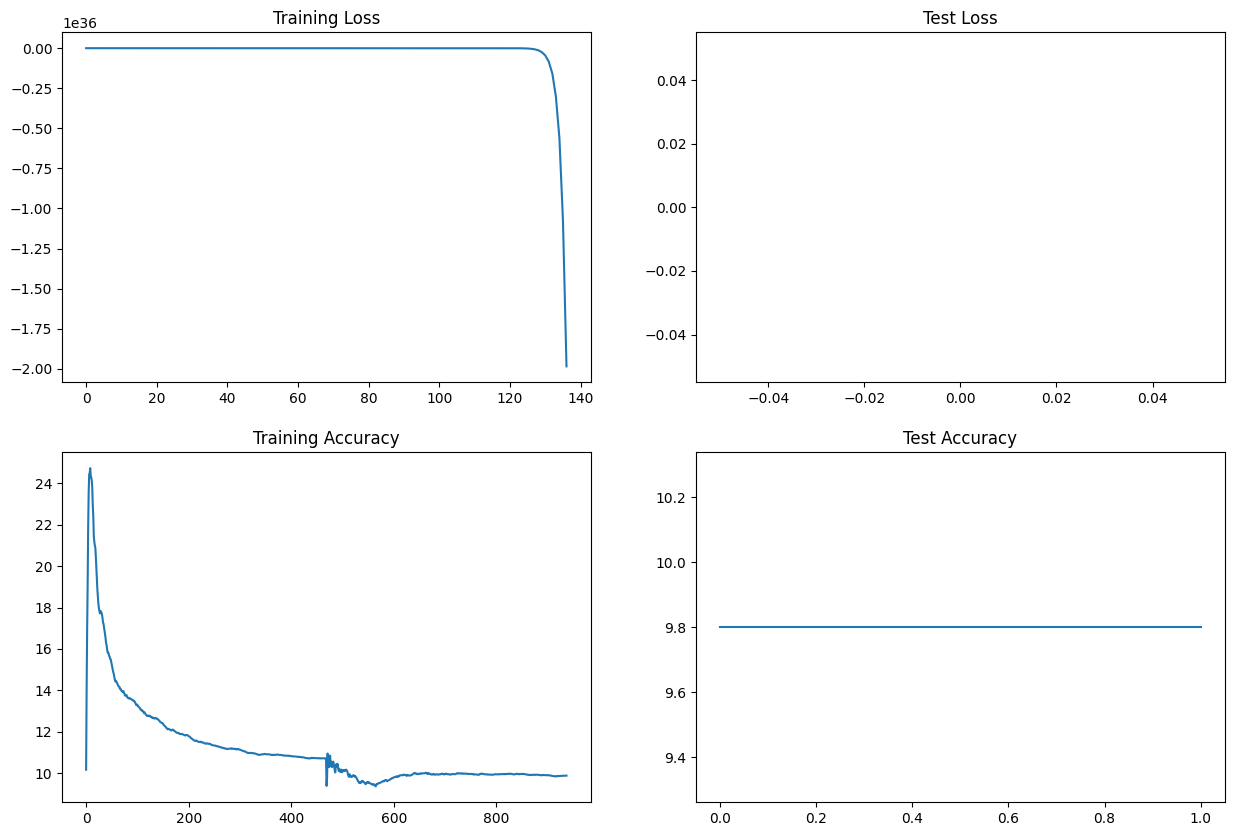

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
# axs[0, 0].plot(train_losses)
axs[0, 0].plot([t.cpu().item() for t in train_losses])
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_accuracy)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_accuracy)
axs[1, 1].set_title("Test Accuracy")